In [1]:
#code cleaning
#add the code to update computing the errors 
#now, it takes twice the region of the r that has been evaluated. 

#*******Check the x, y orientation in calError************************#

### Imports modules and vector fields

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils
import grafteaux as G
import automateG as AG
from scipy.ndimage.measurements import find_objects, label, center_of_mass
import prom2d as PP
import time

G = reload(G)
mat_path = "C:/Users/Lavision/Desktop/CoherentStructures-master/RNV45-RI2.mat"
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()
Umean = Prof['U']

xog = X[0,:]
yog = Y[:,0]

del_x = (xog[0]-xog[1])
ar_th  = del_x*del_x*np.pi*25


current path : C:\Users\Kommalapati sahil\Anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.2439601862683396


### Evaluate the T2 field of the entire frame(s) and find the containing blob radius and prominences


In [3]:
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T
umean2.shape

(123, 242)

In [4]:
#u2d = np.nanmean(U, axis = 2) #local - pixel mean velocity


centers = []
proms = []
areas = []

t2s = []

fr_th = 10 #number of frame to calculate

for frame in range(len(U)):
    s1 = time.time()

    t2f = G.T2_big_mat(X, Y, U[:,:,frame]-umean2, V[:,:,frame], 2)
    
    #t2f cleaning 
    t21 = t2f.copy()
    t21[t2f<0] = 0 #only prograde 
    t21[t2f<2/np.pi/1.5] = 0 #adding some preliminary threshold 0.66%2/pi
    
    #from every frame collect centers and proms
    
    t2s.append(t21)
    
    t2_obs= find_objects(label(t21)[0]) #slice objects
    t2_coms_ = center_of_mass(t21, label(t21)[0], [i+1 for i in range(len(t2_obs))]) #center of masses
    t2_coms = np.array(t2_coms_).astype(int)
    
    peaks,idmap,promap,parentmap = PP.getProminence(t21,0.01,lats=yog,\
                                                    lons=xog,\
                                                    min_area=ar_th,\
                                                    include_edge=True,\
                                                    verbose = False)
    
    print(f'Frame - {frame} done.' )
    
    cent = []
    prom = []
    aa = []
    for i in peaks.keys():
        
        prom_ = peaks[i]['prominence']
        cc = PP.getind(peaks[i]['center'],xog, yog)
        aa_ = peaks[i]['area']
        cc1 = (cc[1], cc[0])
        
        cent.append(cc1)
        prom.append(prom_)
        aa.append(aa_)
    
    centers.append(cent)
    proms.append(prom)
    areas.append(aa)
    
    s2 = time.time()
    print(f'took {round(s2 - s1,2)} secs.')
    
    if frame+1 >= fr_th:     break

#we got centers and proms

Frame - 0 done.
took 401.16 secs.
Frame - 1 done.
took 353.16 secs.
Frame - 2 done.
took 342.46 secs.
Frame - 3 done.
took 277.5 secs.
Frame - 4 done.
took 371.93 secs.
Frame - 5 done.
took 397.08 secs.
Frame - 6 done.
took 418.44 secs.


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


Frame - 7 done.
took 458.75 secs.
Frame - 8 done.
took 488.34 secs.
Frame - 9 done.
took 446.77 secs.


### Functions to get the half prominence regions from the prominence values

In [5]:


def getdims(G):
    '''
    has 1s everywhre
    and 2 at center
    returns ( by-top, by-down, bx-left, bx-right)
    '''
    
    c = np.where(G==2)
    cx, cy  = c[0][0], c[1][0]
    return (cx, len(G)-cx-1, cy, len(G[0])-cy-1)
    
def find_blobs(G, cent, prom, ratio = 0.5, verbose = True):
    '''
    G- the big field
    cent- blob center whose bounds we want
    
    Very naive implementation - can be made significantly faster
    '''
    
    #modify G with prom and ratio
    pr_th = G[cent]-prom*ratio
    G_ = G.copy()
    G_[G<=pr_th] = 0 #only regions with half prom available
    
    G_obs = find_objects(label(G_)[0])
    #print(len(G_obs))
    for i in G_obs:
        #print(i)
        test  = np.zeros(G.shape)
        test[i] = 1
        if test[cent]:
            #this blob contains the cnt
            if verbose:
                plt.figure()
                plt.imshow(test)
                plt.colorbar()
            test[cent] = 2
            dims = getdims(test[i])
            return dims
    return -1

    #indicates that the search was failure 
    #unlikelyy - probably some rounding error somewhere


### Get the extent of the half prominence region from the center

In [6]:
##bbdims array - tales centers and proms and 
#gets the half prom (or some ratio) blob regions.

#can set verbose in find_blobs = False to not visualize the blobs

bbdims = []
for i in range(len(centers)):
    t21 = t2s[i]
        
    #for each frame
    bbcurr = []
    #print('sdfg')
    for cf in range(len(centers[i])):
        bb_ = find_blobs(t21, centers[i][cf], proms[i][cf], ratio = 1, verbose  = False)
        bbcurr.append(bb_)
        #print(bb_)
        #break
    bbdims.append(bbcurr)
    

C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal


### Evaluating MCMC on the localized fields

In [7]:
#we have global cents, global blob dims exact, frame 
#mcmc part 

ct = 0
ct_lim = 10

props_dir = {}

mc_soldir = {}
min_soldir = {}

mc_resdir = {}
min_resdir = {}

samp_dir = {}

height_th = [U.shape[0]*0.2, U.shape[0]*0.4]

In [8]:
#newBBdims, newCents
#calculate the min sol and then compare with mc sol.

from scipy import optimize

y = yog.copy()
x = xog.copy()

SR = 5
bounds = [(0.01*2*np.pi*(x[1]-x[0]), None), (x[1]-x[0],np.max(x)),\
          (-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),(-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),\
          (-0.15, 0.15)]


Circ = 0.08 #circulation strength
r = 0.03    #radius
xc = 0.02  #center.x (?)
yc = 0.02   #center.y (?)
Conv = 0 #convective velocity

target = [Circ,r,xc,yc,Conv]

In [9]:
AG = reload(AG)

In [10]:
def calError(props,cen, f, U, V, Cond, k=1.5):
    #return the difference using r
    s, r, x, y, v = props
    yo, xo = cen
    
    dx = 0.010118516377207676
    #print(r)
    x = int(round(x/dx))
    y = int(round(y/dx))
    
    #print(x,y)
    r*= k
    r = int(round(r/dx))
    #print(r)
    
    x+= xo
    y+= yo
    #print(x, y , r)
    if y-r>=0 and y+r < len(U) and x-r>=0 and x+r+1 < len(U[0]):

        U1 = U[y-r:y+r+1, x-r:x+r+1,f]
        V = V[y-r:y+r+1, x-r:x+r+1,f]
        Un = (U1-Umean[y])/Cond['Uinf']
        
        x1, y1  = G.get_xy_rect(Un.shape[0], Un.shape[1])
        #print(x1.shape, Un.shape)
        m_res = PODutils.minfuncVecField10r_rect(props, Un, V, x1, y1)
        return m_res
    else : 
        #print(y-r>=0 , y+r < len(U) , x-r>=0 , x+r+1 < len(U[0]))
        return 0  
    

In [11]:
# m_res = calError(match.x, center, frame, U, V,Cond, k = 1.5 )

In [34]:

ct = 0
ct_lim = 1
bc = 0
f3_count = 0
AG = reload(AG)
for i in range(len(centers)):
    #for each frame 
    for  j in range(len(centers[i])):
        
        if bbdims[i][j] == -1 : print('bbdims fail.'); continue 
        
        print(f'working on vrtex - {ct}.')
        b1, b2, b3, b4 = bbdims[i][j]
        cy, cx = centers[i][j]
        
        if cy >= height_th[0] and cy <= height_th[1]: 
            
                
            if not (b1+b2+1) %2 : b2 +=1
            if not (b3+b4+1) %2 : b4 +=1

            uu = U[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            vv = V[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            ss = Swirl[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]

            uun = (uu-Umean[cy])/Cond['Uinf']

            x1, y1  = G.get_xy_rect(uu.shape[0], uu.shape[1])
            
            samp_test = G.doMCMC_V4(uun, vv, x1, y1)
            
            bbs = bbdims[i][j]
            center = centers[i][j]
            frame = i 
            
            p1 = {}
            p1['bbdims'] = np.array(bbs)
            print(bbs)
            p1['cent'] = center
            p1['frame'] = frame
            props_dir[ct] = p1 
            
            f3 = AG.F3check(samp_test,5000,95)
            
            init = target.copy()

            match = optimize.minimize(PODutils.minfuncVecField10r_rect, x0=init, args=(uun,vv,x1,y1) ,bounds=bounds,\
                             method = 'TNC',options={'maxiter':100000,'disp': True}) #'gtol': 1e-6,

            min_soldir[ct] = match.x
            #m_res = PODutils.minfuncVecField10r_rect(match.x, uun, vv, x1, y1)
            m_res = calError(match.x,center, frame, U, V,Cond, k = 1.5 )
            min_resdir[ct] = m_res
            
            if not f3: 
                #store sampler, mc sol, mc res, min sol, min res
                bc +=1 
                samp_dir[ct] = samp_test
                mc_soldir[ct] = AG.cornerSol(samp_test, 5000)
                mc_res = calError(mc_soldir[ct], center, frame, U, V,Cond, k = 1.5 )
                #mc_resdir[ct] = PODutils.minfuncVecField10r_rect(mc_soldir[ct], uun, vv, x1, y1)
                mc_resdir[ct] = mc_res
                
                
            else: 
                
                f3_count+=1 
                #do corrections et al. 
                print(f'Corrections on the vortex - {ct}.')
                props = props_dir[ct]
                solZip = AG.DcorrectionV4(Cond, U, V, Umean, props, samp_test)
                if solZip !=  -1:
                    samp_dir[ct] = solZip[0]
                    props_dir[ct]['bbdims'] = solZip[1]
                    mc_resdir[ct] = solZip[2]
                else: 
                    samp_dir[ct] = samp_test 
                    mc_resdir[ct] = -1 
            print(f'vortex - {ct} done.')
            ct+=1
            #if ct>= ct_lim: break
    #else: continue 
    #break #comes here when break in loop executed
        

working on vrtex - 0.
(3, 5, 8, 7)
Corrections on the vortex - 0.
working on rad: (4, 6, 9, 9)  rth- 16
working on rad: (5, 7, 10, 10)  rth- 16
working on rad: (6, 8, 11, 11)  rth- 16
working on rad: (7, 9, 12, 12)  rth- 16
working on rad: (8, 10, 13, 13)  rth- 16
working on rad: (9, 11, 14, 14)  rth- 16
working on rad: (10, 12, 15, 15)  rth- 16
working on rad: (11, 13, 16, 16)  rth- 16
threshold reached!
vortex - 0 done.
working on vrtex - 1.
(4, 3, 11, 2)
Corrections on the vortex - 1.
working on rad: (5, 5, 12, 4)  rth- 22
working on rad: (6, 6, 13, 5)  rth- 22
working on rad: (7, 7, 14, 6)  rth- 22
working on rad: (8, 8, 15, 7)  rth- 22
working on rad: (9, 9, 16, 8)  rth- 22
working on rad: (10, 10, 17, 9)  rth- 22
working on rad: (11, 11, 18, 10)  rth- 22
working on rad: (12, 12, 19, 11)  rth- 22
out of bounds!
vortex - 1 done.
working on vrtex - 2.
(4, 3, 9, 4)
vortex - 2 done.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrte

working on rad: (9, 7, 19, 13)  rth- 32
working on rad: (10, 8, 20, 14)  rth- 32
working on rad: (11, 9, 21, 15)  rth- 32
working on rad: (12, 10, 22, 16)  rth- 32
(15,) (15, 15)
vortex - 31 done.
working on vrtex - 32.
(11, 6, 11, 7)
vortex - 32 done.
working on vrtex - 33.
working on vrtex - 33.
(7, 7, 8, 8)
vortex - 33 done.
working on vrtex - 34.
(7, 7, 11, 10)
vortex - 34 done.
working on vrtex - 35.
working on vrtex - 35.
(10, 7, 8, 5)
vortex - 35 done.
working on vrtex - 36.
working on vrtex - 36.
(7, 6, 9, 6)
Corrections on the vortex - 36.
working on rad: (8, 8, 10, 8)  rth- 18
working on rad: (9, 9, 11, 9)  rth- 18
working on rad: (10, 10, 12, 10)  rth- 18
working on rad: (11, 11, 13, 11)  rth- 18
working on rad: (12, 12, 14, 12)  rth- 18
(39,) (39, 39)
vortex - 36 done.
working on vrtex - 37.
(4, 5, 3, 6)
Corrections on the vortex - 37.
working on rad: (5, 7, 4, 8)  rth- 12
working on rad: (6, 8, 5, 9)  rth- 12
working on rad: (7, 9, 6, 10)  rth- 12
(25,) (25, 25)
vortex - 3

In [35]:
AG = reload(AG)

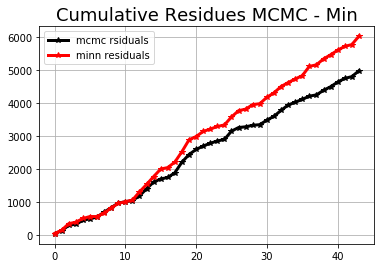

In [36]:
lkeys = [i for i in samp_dir.keys() if mc_resdir[i] != -1]

samps = [samp_dir[l] for l in lkeys]
mc_res = [mc_resdir[l] for l in lkeys]
min_res = [min_resdir[l] for l in lkeys]

plt.figure()
plt.plot(np.cumsum(mc_res), '*-k', lineWidth = '3', label = 'mcmc rsiduals')
plt.plot(np.cumsum(min_res), '*-r', lineWidth = '3', label = 'minn residuals')
plt.grid()
plt.title('Cumulative Residues MCMC - Min', fontSize = 18)
plt.legend()
plt.show()

In [37]:
print(f'Average residual error for mcm - ', np.mean(mc_res))
print(f'Average residual error for minn - ', np.mean(min_res))


Average residual error for mcm -  112.98499717062495
Average residual error for minn -  136.76293976345178


In [38]:
print(f' Success before corrections-  {round(bc/len([i for i in mc_resdir.keys()])*100, 3)} %')
print(f' Success after corrections-  {round(len(lkeys)/len([i for i in mc_resdir.keys()])*100, 3)} %')

 Success before corrections-  35.0 %
 Success after corrections-  73.333 %


### Big Histograms of all the solutions

In [39]:
len([i for i in mc_resdir.keys()])

60

In [40]:
import matplotlib.mlab as mlab

def bigHist(sol_dir):
    SS, R, X, Y, CV = [], [], [], [], []
    T = ['SS', 'R', 'X', 'Y', 'CV'] 
    T2 = ['Swirling Strength', 'Radius', 'X-position', 'Y-position', 'Convective Velocity']
    for i in sol_dir.keys():
        if len(sol_dir[i]) == 1: continue 
        se = sol_dir[i]
        SS.append(se[0])
        R.append(se[1])
        X.append(se[2])
        Y.append(se[3])
        CV.append(se[4])
    ii = 0
    x_ = []
    y_ = []
    for i in [SS, R, X, Y, CV]:
        if len(SS) == 0: return
        plt.figure()
        a, b = np.histogram(i)
        b_  = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
        plt.plot(b_, a/np.max(a), '-y', lineWidth = 3, label = 'Trend line')
        x_.append(b_)
        y_.append(a/np.max(a))
        
        #p1 = mlab.normpdf( bins, mu, sigma)
        #l = plt.plot(b_, p1, 'r--', linewidth=2)
        
        a, b = np.histogram(i, bins = 50)
        b_  = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
        plt.plot(b_,a/np.max(a),'-g', lineWidth = 2 , label = 'True Data')
        #plt.plot(b_, p(b_), '-r', lineWidth = 3)
        plt.grid()
        #plt.xlabel(T[ii])
        #plt.ylabel('Normalized Count Magnitude')
        plt.legend()
        plt.title(T2[ii]+' Histogram', fontSize  = 15)
        ii+=1
    return x_, y_
        

In [41]:
len(min_soldir.keys())

60

In [42]:
min_soldir2 = {}
for i in lkeys:
    min_soldir2[i] = min_soldir[i]

In [43]:
min_soldir[1]

array([ 0.12370418,  0.09372336,  0.05059258, -0.0092997 , -0.10081282])

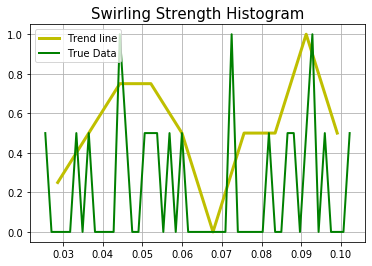

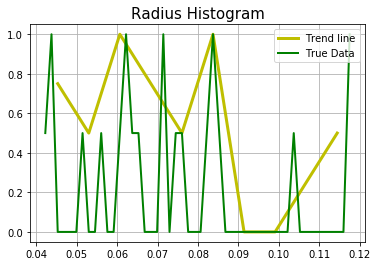

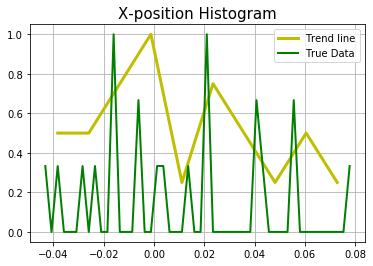

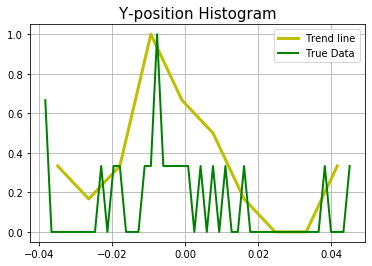

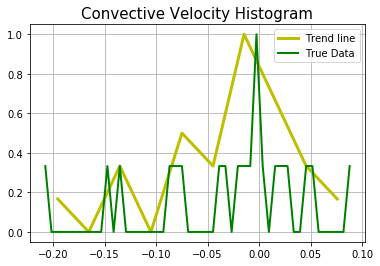

In [44]:
#mnx, mny = bigHist(min_soldir)
mcx, mcy = bigHist(mc_soldir)


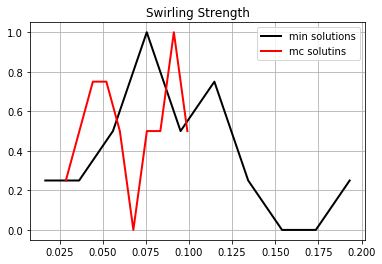

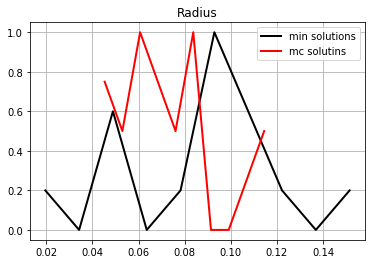

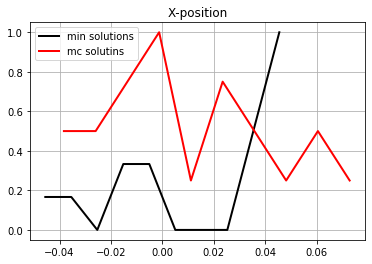

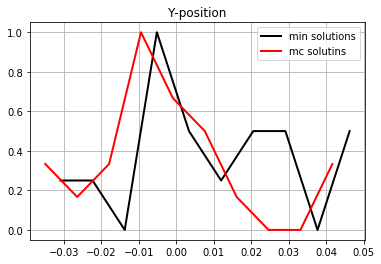

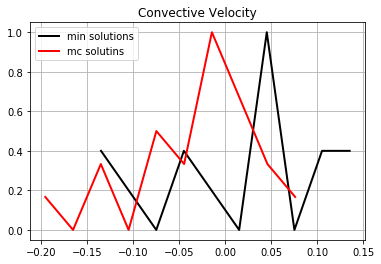

In [45]:
T2 = ['Swirling Strength', 'Radius', 'X-position', 'Y-position', 'Convective Velocity']

for i in range(5):
    plt.figure()
    plt.plot(mnx[i], mny[i], '-k', label = 'min solutions', lineWidth = 2)
    plt.plot(mcx[i], mcy[i], '-r', label = 'mc solutins', lineWidth = 2)
    plt.grid()
    plt.legend()
    plt.title(T2[i])
    plt.savefig(T2[i])
    
    

11 10
11 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

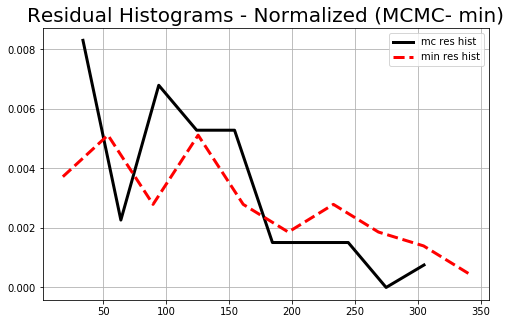

In [46]:
def resHist(resdir, verbose = True):
    res = []
    plt.figure()
    for i in resdir.keys():
        if resdir[i] != -1:
            res.append(resdir[i])
    a,b = np.histogram(res, density  = True)
    print(len(b),len(a))
    
    b_ = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
    if verbose:
        plt.plot(b_,a)
        plt.grid()
    return  b_, a

x1, y1 = resHist(mc_resdir, verbose  = False)
x2, y2 = resHist(min_resdir, verbose = False)

plt.figure(figsize = (8,5))
plt.plot(x1, y1,'-k', label = 'mc res hist', lineWidth = 3)
plt.plot(x2, y2, '--r', label  = 'min res hist', lineWidth = 3)
plt.grid()
plt.legend()
plt.title('Residual Histograms - Normalized (MCMC- min)', fontSize = 20)
plt.show()

In [ ]:
len(lkeys)